# Regression 2 - using new cleaning and dummifying methods
- will also include removed columns and new columns we added as discussed in our group meeting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from data_preprocessing_final2 import *

In [70]:
#set columns
pd.set_option("display.max_columns",None)

#set rows
pd.set_option("display.max_rows",None)

### read our file and clean, re-classify, train/test split, and scale our data 

In [2]:
# read our original data file
data = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)

In [3]:
# taking only Normal Sale conditions to make apples to apples comparison for Sales Price (majority were Normal)
data = data[data['SaleCondition'] == 'Normal']

In [4]:
# this function will clean, dummify/ord, test/train split, and scale all our data
train_data_linear, train_target_linear, test_data_linear, test_target_linear, train_data_tree, train_target_tree, test_data_tree, test_target_tree = initiate_data(data)

In [5]:
train_data_linear.head()

,PID,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_Reg,LandContour_HLS,LandContour_Low,...,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,TotalBath,Bsmt_Unfin_Ratio,TotalLivArea
0,531450030,0,0,0,0,1,0,1,0,0,...,0.844037,0.340054,0.134831,0.149123,0.0,0.0,0.0,0.333333,0.525120,0.348428
1,535476360,0,0,0,0,1,0,1,0,0,...,0.587156,0.295699,0.167837,0.073684,0.0,0.0,0.0,0.250000,0.205596,0.363990
2,905109170,0,0,0,0,1,0,0,0,1,...,0.706422,0.463710,0.348315,0.000000,0.0,0.0,0.0,0.250000,0.230986,0.399782
3,535101110,0,0,0,0,1,0,0,0,0,...,0.614679,0.340054,0.000000,0.000000,0.0,0.0,0.0,0.166667,1.000000,0.441021
4,528228565,0,0,0,0,1,0,1,0,0,...,0.963303,0.295699,0.099719,0.035088,0.0,0.0,0.0,0.166667,0.988253,0.394336


### new calling method for our train/test split and clean
- this will be a linear regression model

only using:
- train_data_linear, train_target_linear
- test_data_linear, test_target_linear

In [6]:
train_data_linear.shape

(1926, 236)

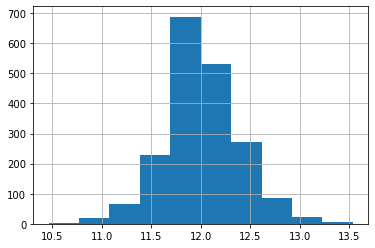

In [7]:
train_target_linear.hist()

In [8]:
# need to delete PID to run the Regression models
del train_data_linear['PID']
del test_data_linear['PID']

# model was built out using these variables so going to redefine our 
# train_data_linear, train_target_linear, test_data_linear, test_target_linear
x_train = train_data_linear
Y_train = train_target_linear

x_test = test_data_linear
Y_test = test_target_linear

# Attempt on Ridge Regression
- using our own alpharange
- using GridSearch

### Manually setting AlphaRange
- selecting 1e-3 to 200 with 1000 #s as my alpha testing
- graphs to show coefficient and R2 against alpha

In [9]:
ridge = Ridge()

In [10]:
coefs = []
intercepts = []
train_R2  = []
test_R2 = []
alphaRange = np.linspace(1e-3,200,1000)
for alpha in alphaRange:
          ridge.set_params(alpha=alpha, normalize=False)  
          ridge.fit(x_train,Y_train)
          intercepts.append(ridge.intercept_)
          coefs.append(ridge.coef_)
          train_R2.append(ridge.score(x_train,Y_train))
          test_R2.append(ridge.score(x_test,Y_test))

In [11]:
# creating default graph settings
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (7,7)

### Trying to find optimal Alpha where train/test R2 converge
- print out list of coefficients to compare
- check our r-squared values for our train/test data after selecting an optimal alpha

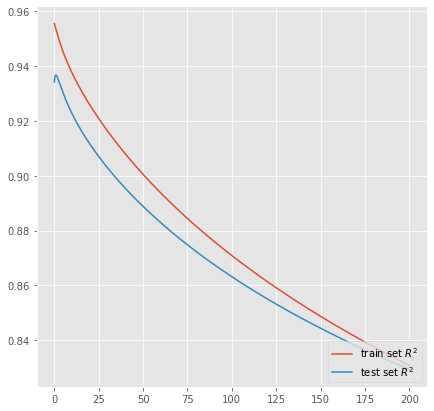

In [12]:
plt.plot(alphaRange, train_R2, label=r'train set $R^2$')
plt.plot(alphaRange, test_R2, label=r'test set $R^2$')
plt.legend(loc=4)

# MUCH closer than before.. less overfitting it looks like
# assume alpha is optimal at 5?

### List of Coefficients

In [13]:
ridge.set_params(alpha=5)
ridge.fit(x_test, Y_test)
coefDF = pd.Series(ridge.coef_.reshape(-1,), index=x_test.columns) #not sure why this wasn't working
print('The intercept is %.4f' %(ridge.intercept_))
print('The slopes are \n %s' %(coefDF))

The intercept is 11.6401
The slopes are 
 MSZoning_C (all)   -0.061053
MSZoning_FV         0.047988
MSZoning_I (all)    0.000000
MSZoning_RH         0.021347
MSZoning_RL         0.040697
                      ...   
3SsnPorch           0.001633
ScreenPorch         0.037726
TotalBath           0.135327
Bsmt_Unfin_Ratio   -0.025937
TotalLivArea        0.296769
Length: 235, dtype: float64


In [14]:
df_coef = pd.DataFrame(coefDF, columns = ['Coefficient'])

In [15]:
df_coef.sort_values(by=['Coefficient'])

,Coefficient
OverallQual_4,-0.132528
OverallCond_3,-0.121805
BldgType_Twnhs,-0.078781
FireplaceQu_No_Fireplace,-0.075615
KitchenQual_TA,-0.070024
...,...
TotRmsAbvGrd,0.133216
TotalBath,0.135327
OverallQual_9,0.141184
GarageArea,0.164814


In [16]:
# Fit our model to the optimal alpha=5 and see what our R-Squared is
ridge.set_params(alpha=5)
ridge.fit(x_train, Y_train)
print(ridge.get_params())
print("Train R-Squared:", ridge.score(x_train,Y_train))
print("Test R-Squared:", ridge.score(x_test,Y_test))

# .935 test!

{'alpha': 5, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
Train R-Squared: 0.9450048752971545
Test R-Squared: 0.9300092086327935


### Using GridSearch 
- do the same as above but using GridSearch
- setting a different alphaRange for this one, 0.001 to 100 with 1000 numbers

In [17]:
alphaRange = np.linspace(0.001,100,1000)

#setting our params using alphaRange for our GridSearch
params = {'alpha': alphaRange, 'max_iter': [1000000]}

In [18]:
#creating grid object
grid = GridSearchCV(ridge, params, cv=5, scoring = 'r2')

#fitting it to our training data
grid.fit(x_train, Y_train)

GridSearchCV(cv=5, estimator=Ridge(alpha=5),
             param_grid={'alpha': array([1.00000000e-03, 1.01099099e-01, 2.01198198e-01, 3.01297297e-01,
       4.01396396e-01, 5.01495495e-01, 6.01594595e-01, 7.01693694e-01,
       8.01792793e-01, 9.01891892e-01, 1.00199099e+00, 1.10209009e+00,
       1.20218919e+00, 1.30228829e+00, 1.40238739e+00, 1.50248649e+00,
       1.60258559e+00, 1.70268468e+00, 1.80278378...
       9.76977207e+01, 9.77978198e+01, 9.78979189e+01, 9.79980180e+01,
       9.80981171e+01, 9.81982162e+01, 9.82983153e+01, 9.83984144e+01,
       9.84985135e+01, 9.85986126e+01, 9.86987117e+01, 9.87988108e+01,
       9.88989099e+01, 9.89990090e+01, 9.90991081e+01, 9.91992072e+01,
       9.92993063e+01, 9.93994054e+01, 9.94995045e+01, 9.95996036e+01,
       9.96997027e+01, 9.97998018e+01, 9.98999009e+01, 1.00000000e+02]),
                         'max_iter': [1000000]},
             scoring='r2')

In [20]:
print(grid.best_params_) #0.7016936936936937 is the best alpha according to gridSearch

{'alpha': 0.3012972972972973, 'max_iter': 1000000}


In [21]:
# re-fitting our ridge using the new alpha
ridge.set_params(alpha=0.7016936936936937)
ridge.fit(x_train, Y_train)
print(ridge.get_params())
print("Train R-Squared:", ridge.score(x_train,Y_train))
print("Test R-Squared:", ridge.score(x_test,Y_test))

## for VotingRegressor
ridge_optimal = Ridge(alpha=0.7016936936936937, max_iter=1000000)

# testing has a 0.938!

{'alpha': 0.7016936936936937, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
Train R-Squared: 0.9538486975270881
Test R-Squared: 0.9366406387334304


# Attempt on Lasso Regression
- trying it with setting our alpharange manually
- then trying to see how it compares to GridSearch

In [19]:
#create our lasso object
lasso = Lasso()

In [25]:
coefs1 = []
intercepts1 = []
train_R2a  = []
test_R2a = []
alphaRange1 = np.linspace(1e-3,0.03,1000)
for alpha in alphaRange1:
          lasso.set_params(alpha=alpha, normalize=False)  
          lasso.fit(x_train,Y_train)
          intercepts1.append(lasso.intercept_)
          coefs1.append(lasso.coef_)
          train_R2a.append(lasso.score(x_train,Y_train))
          test_R2a.append(lasso.score(x_test,Y_test))

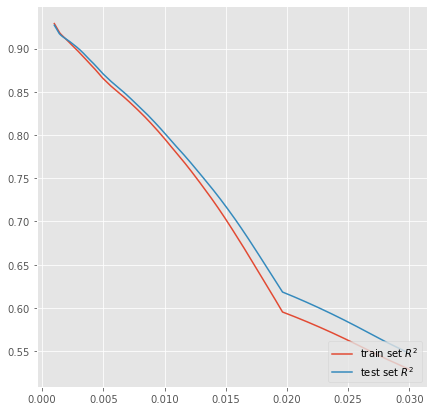

In [26]:
plt.plot(alphaRange1, train_R2a, label=r'train set $R^2$')
plt.plot(alphaRange1, test_R2a, label=r'test set $R^2$')
plt.legend(loc=4)

# can't really tell where Alpha is optimal, will use GridSearch
# chart is even better after our feature selection process

### GridSearch for Lasso

In [28]:
alphaRange1 = np.linspace(1e-3,0.05,1000)

#setting our params using alphaRange for our GridSearch
params1 = {'alpha': alphaRange1, 'max_iter' : [1000000]}

In [29]:
#creating grid object
grid1 = GridSearchCV(lasso, params1, cv=5, scoring = 'r2')

#fitting it to our training data
grid1.fit(x_train, Y_train)

GridSearchCV(cv=5, estimator=Lasso(alpha=0.03),
             param_grid={'alpha': array([0.001     , 0.00104905, 0.0010981 , 0.00114715, 0.0011962 ,
       0.00124525, 0.00129429, 0.00134334, 0.00139239, 0.00144144,
       0.00149049, 0.00153954, 0.00158859, 0.00163764, 0.00168669,
       0.00173574, 0.00178478, 0.00183383, 0.00188288, 0.00193193,
       0.00198098, 0.00203003, 0.00207908, 0.00212813, 0.00217718,
       0.0022262...
       0.04857758, 0.04862663, 0.04867568, 0.04872472, 0.04877377,
       0.04882282, 0.04887187, 0.04892092, 0.04896997, 0.04901902,
       0.04906807, 0.04911712, 0.04916617, 0.04921522, 0.04926426,
       0.04931331, 0.04936236, 0.04941141, 0.04946046, 0.04950951,
       0.04955856, 0.04960761, 0.04965666, 0.04970571, 0.04975475,
       0.0498038 , 0.04985285, 0.0499019 , 0.04995095, 0.05      ]),
                         'max_iter': [1000000]},
             scoring='r2')

In [30]:
print(grid1.best_params_) #0.001 is the best alpha according to gridSearch

{'alpha': 0.001, 'max_iter': 1000000}


In [31]:
# re-fitting our lasso using the new alpha
lasso.set_params(alpha=0.001)
lasso.fit(x_train, Y_train)
print(lasso.get_params())
print("Train R-Squared:", lasso.score(x_train,Y_train))
print("Test R-Squared:", lasso.score(x_test,Y_test))

## for VotingRegressor
lasso_optimal = Lasso(alpha=0.001, max_iter=1000000)

# test score of 0.927

{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
Train R-Squared: 0.9289129159748201
Test R-Squared: 0.9270027362907779


In [32]:
coefDF1 = pd.Series(lasso.coef_.reshape(-1,), index=x_train.columns)
print('The intercept is %.4f' %(lasso.intercept_))
print('The slopes are \n %s' %(coefDF1))

The intercept is 11.2709
The slopes are 
 MSZoning_C (all)   -0.000000
MSZoning_FV         0.038005
MSZoning_I (all)   -0.000000
MSZoning_RH        -0.000000
MSZoning_RL         0.053029
                      ...   
3SsnPorch           0.000000
ScreenPorch         0.005145
TotalBath           0.118574
Bsmt_Unfin_Ratio   -0.062507
TotalLivArea        1.311514
Length: 235, dtype: float64


In [33]:
df_coef1 = pd.DataFrame(coefDF1, columns = ['Coefficient']).sort_values(by=['Coefficient'])
df_coef1

,Coefficient
OverallCond_3,-0.145873
OverallQual_2,-0.081035
MSSubClass_30,-0.077760
OverallQual_4,-0.072245
OverallCond_4,-0.072163
...,...
OverallQual_8,0.098370
TotalBath,0.118574
OverallQual_9,0.190293
GarageArea,0.222283


In [34]:
# let's all find all the 0 coefficients
print(df_coef1.shape)
print(df_coef1[df_coef1['Coefficient'] == 0].shape)
df_coef1[df_coef1['Coefficient'] == 0]

(235, 1)
(150, 1)


,Coefficient
HeatingQC_Po,0.0
GarageType_CarPort,0.0
BsmtCond_No_Basement,0.0
GarageType_Basment,-0.0
FireplaceQu_TA,-0.0
...,...
Exterior1st_Stucco,0.0
Exterior1st_HdBoard,-0.0
Exterior1st_WdShing,0.0
Exterior1st_Plywood,-0.0


# Attempt on ElasticNet
- repeating analysis with ElasticNet
- using GridSearch

In [35]:
#create our lasso object
enet = ElasticNet()

### ElasticNet with GridSearch

In [36]:
#what we used previously
alphaSize = 200
rhoSize = 10
alphaRange2 = np.linspace(1e-3,100, alphaSize)
rhoRange = np.linspace(0.01, 1, rhoSize)


#setting our params using alphaRange for our GridSearch
params2 = {'alpha': alphaRange2, 'l1_ratio': rhoRange, 'max_iter' : [1000000]}

In [38]:
#creating grid object
grid2 = GridSearchCV(enet, params2, cv=5, scoring = 'r2')

#fitting it to our training data
grid2.fit(x_train, Y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e-03, 5.03507538e-01, 1.00601508e+00, 1.50852261e+00,
       2.01103015e+00, 2.51353769e+00, 3.01604523e+00, 3.51855276e+00,
       4.02106030e+00, 4.52356784e+00, 5.02607538e+00, 5.52858291e+00,
       6.03109045e+00, 6.53359799e+00, 7.03610553e+00, 7.53861307e+00,
       8.04112060e+00, 8.54362814e+00, 9.04613568e+...
       9.04523568e+01, 9.09548643e+01, 9.14573719e+01, 9.19598794e+01,
       9.24623869e+01, 9.29648945e+01, 9.34674020e+01, 9.39699095e+01,
       9.44724171e+01, 9.49749246e+01, 9.54774322e+01, 9.59799397e+01,
       9.64824472e+01, 9.69849548e+01, 9.74874623e+01, 9.79899698e+01,
       9.84924774e+01, 9.89949849e+01, 9.94974925e+01, 1.00000000e+02]),
                         'l1_ratio': array([0.01, 0.12, 0.23, 0.34, 0.45, 0.56, 0.67, 0.78, 0.89, 1.  ]),
                         'max_iter': [1000000]},
             scoring='r2')

In [39]:
print(grid2.best_params_) #0.001 is the best alpha with a l1_ratio of 0.12

{'alpha': 0.001, 'l1_ratio': 0.12, 'max_iter': 1000000}


In [40]:
# re-fitting our ElasticNet using the new alpha and rho
enet.set_params(alpha=0.001, l1_ratio=0.01)
enet.fit(x_train, Y_train)
print(enet.get_params())
print("Train R-Squared:", enet.score(x_train,Y_train))
print("Test R-Squared:", enet.score(x_test,Y_test))

## for VotingRegressor
enet_optimal = ElasticNet(alpha=0.001, l1_ratio=0.12, max_iter=1000000)

# pretty close with Ridge, 0.939!

{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.01, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
Train R-Squared: 0.9510883237675039
Test R-Squared: 0.9390747194358329


### VotingRegressor
- using the VotingRegressor with Lasso, Ridge and ElasticNet


#### VotingRegressor:
- Prediction voting regressor for unfitted estimators.
- A voting regressor is an ensemble meta-estimator that fits several base regressors, each on the whole dataset. Then it averages the individual predictions to form a final prediction.

In [41]:
vr = VotingRegressor([('lasso', lasso_optimal), ('ridge', ridge_optimal), ('elasticnet', enet_optimal)])

vr.fit(x_train, Y_train)
vr.score(x_test, Y_test)

## VotingRegressor gave a score of 0.94!

0.940393727584611